In [1]:
import json
import csv
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
import datetime
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
import preprocessor as p

In [2]:
imdb_df = pd.read_json('../data/imdb_TvShows_data.json')

In [3]:
imdb_df.keys()

Index(['Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director',
       'Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Poster',
       'Ratings', 'Metascore', 'imdbRating', 'imdbVotes', 'imdbID', 'Type',
       'totalSeasons', 'Response', 'review', 'DVD', 'BoxOffice', 'Production',
       'Website'],
      dtype='object')

In [4]:
imdb_df.shape

(19, 27)

In [5]:
all_reviews = []
for idx, row in imdb_df.iterrows():
    for review in row['review']:
        record = {}
        record['Title'] = row['Title']
        record['Year'] = row['Year']
        record['Released'] = row['Released']
        record['Genre'] = row['Genre']
        record['Actors'] = row['Actors']
        record['imdbRating'] = row['imdbRating']
        record['imdbVotes'] = row['imdbVotes']
        record['Review'] = review
        all_reviews.append(record)
show_review_df = pd.DataFrame(all_reviews)

In [6]:
stopwords = set(STOPWORDS)

In [7]:
def generate_wordcloud_data(data):
    words = ''
    for record in data:
        record = record.lower()
        tokens = record.split()
        words += ' '.join(tokens)+' '
    return words

In [8]:
show_review_df.shape

(25228, 8)

In [9]:
show_review_df['Title'].nunique()

19

We collected reviews from IMDb for 19 shows. Across all of them, we have 25,228 reviews.

In [10]:
review_words = generate_wordcloud_data(list(show_review_df['Review']))

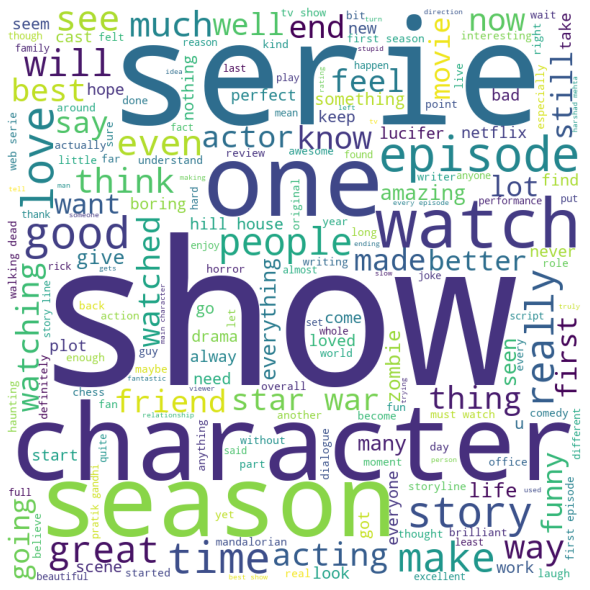

In [11]:
review_wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(review_words)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(review_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

Above, we show a wordcloud of all the reviews that have been accumulated. The most common words in the review seem to be reference to the shows themselves, common nouns for the same.

In [12]:
genre_words = generate_wordcloud_data(list(imdb_df['Genre']))

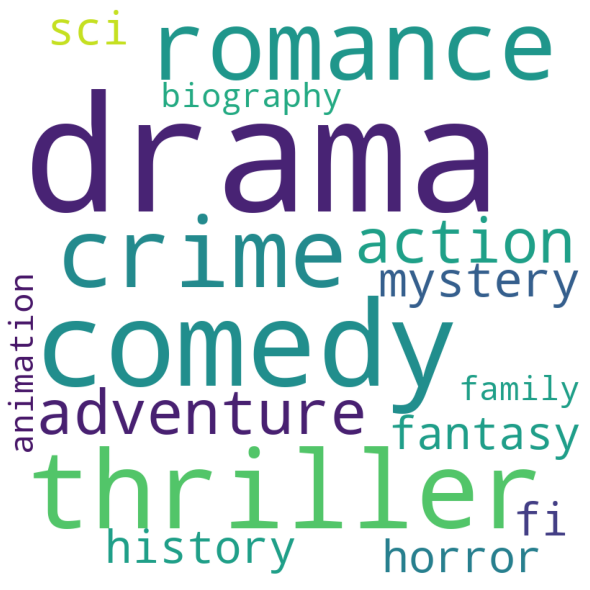

In [13]:
genre_wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(genre_words)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(genre_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

Here, we plotted a word cloud of the different genres covered by the TV shows in question. The most common genre that is associated with these TV shows is drama.

In [14]:
def sentiment_analysis(text):
    output = TextBlob(text)
    return output.sentiment.polarity

In [15]:
show_review_df['sentiment_score'] = show_review_df['Review'].apply(lambda x: sentiment_analysis(x))

In [16]:
show_review_df['sentiment_score'].describe()

count    25228.000000
mean         0.200939
std          0.292474
min         -1.000000
25%          0.000000
50%          0.187296
75%          0.370833
max          1.000000
Name: sentiment_score, dtype: float64

In [17]:
show_sentiment = show_review_df.groupby('Title')['sentiment_score'].mean().to_dict()

In [18]:
imdb_df['avg_sentiment'] = imdb_df['Title'].map(show_sentiment)

In [19]:
imdb_df.sort_values(by=['avg_sentiment'], ascending=False)[['Title', 'avg_sentiment', 'imdbRating']]

,Title,avg_sentiment,imdbRating
5,Scam 1992: The Harshad Mehta Story,0.411886,9.6
10,The Queen's Gambit,0.310000,8.9
17,Lucifer,0.247930,8.2
13,Schitt's Creek,0.246548,8.5
18,Friends,0.226610,8.9
12,The Office,0.210278,8.9
7,The Mandalorian,0.186022,8.7
0,Young Sheldon,0.183517,7.4
6,Mirzapur,0.182055,8.4
3,The Crown,0.178433,8.7


<AxesSubplot:ylabel='Title'>

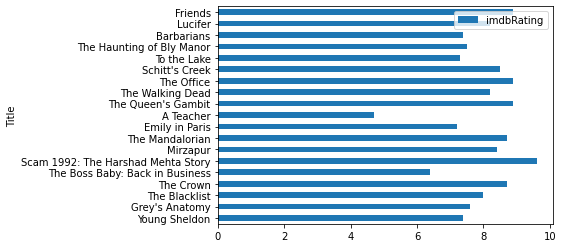

In [20]:
imdb_df[['Title', 'imdbRating']].plot.barh(x='Title')

Above, we can see the TV shows sorted in descending order of average sentiment score.

In [21]:
imdb_df.sort_values(by=['imdbRating'], ascending=False)[['Title', 'avg_sentiment', 'imdbRating']]

,Title,avg_sentiment,imdbRating
5,Scam 1992: The Harshad Mehta Story,0.411886,9.6
18,Friends,0.226610,8.9
10,The Queen's Gambit,0.310000,8.9
12,The Office,0.210278,8.9
3,The Crown,0.178433,8.7
7,The Mandalorian,0.186022,8.7
13,Schitt's Creek,0.246548,8.5
6,Mirzapur,0.182055,8.4
17,Lucifer,0.247930,8.2
11,The Walking Dead,0.089380,8.2


<AxesSubplot:ylabel='Title'>

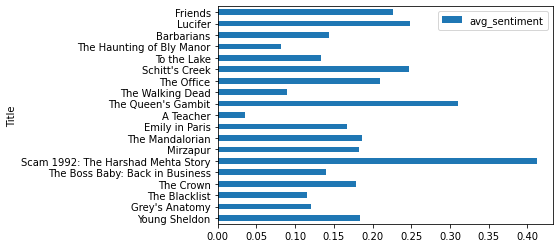

In [22]:
imdb_df[['Title', 'avg_sentiment']].plot.barh(x='Title')

Above, we can see the TV shows sorted in descending order of IMDb score.

In [23]:
imdb_df['avg_sentiment'].corr(imdb_df['imdbRating'])

0.7353057203098952

We see that the sentiment score extracted from IMDb reviews is highly correlated with its rating.

In [24]:
def tokens_of_text(text):
    tokens = text.split()
    clean_tokens = [token for token in tokens if token not in list(stopwords)]
    return clean_tokens

In [25]:
show_review_df['review_tokens'] = show_review_df['Review'].apply(lambda x: tokens_of_text(x))

In [26]:
list_of_list_of_tokens = list(show_review_df['review_tokens'])

In [27]:
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

In [28]:
# number of topics is the number of shows
num_topics = imdb_df.shape[0]
# learn a topic model
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 42.7 s, sys: 383 ms, total: 43.1 s
Wall time: 40.7 s


In [29]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.028*"version" + 0.026*"American" + 0.017*"office" + 0.017*"The" + 0.016*"work" + 0.015*"witty" + 0.013*""The" + 0.013*"playing" + 0.012*"And" + 0.012*"u"


Topic: 1 
Words: 0.048*"Star" + 0.035*"..." + 0.033*"original" + 0.029*"The" + 0.017*"production" + 0.016*"This" + 0.016*"fans" + 0.014*"comedic" + 0.012*"It" + 0.012*"movie."


Topic: 2 
Words: 0.094*"I" + 0.028*"show" + 0.013*"think" + 0.013*"really" + 0.012*"The" + 0.009*"much" + 0.009*"love" + 0.009*"characters" + 0.008*"I'm" + 0.007*"still"


Topic: 3 
Words: 0.085*"season" + 0.028*"I" + 0.026*"first" + 0.022*"episodes" + 0.021*"episode" + 0.020*"Season" + 0.018*"seasons" + 0.016*"2" + 0.016*"5" + 0.016*"4"


Topic: 4 
Words: 0.138*"I" + 0.023*"watch" + 0.018*"watching" + 0.017*"show" + 0.014*"will" + 0.014*"watched" + 0.013*"series" + 0.012*"one" + 0.011*"love" + 0.011*"never"


Topic: 5 
Words: 0.047*"." + 0.046*"," + 0.016*"The" + 0.008*"series" + 0.008*"sometimes" + 0.007*"full" + 0.007*"life" + 0.007*"pl

In [30]:
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)

In [31]:
pyLDAvis.enable_notebook()

In [32]:
pyLDAvis.display(vis)

In [33]:
df = pd.read_json('../data/twitter_data/ateacher.json')
df['tv_show_name'] = 'A Teacher'
twitter_df = df.copy()

df = pd.read_json('../data/twitter_data/Barbarians.json')
df['tv_show_name'] = 'Barbarians'
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/emilyinparis.json')
df['tv_show_name'] = 'Emily in Paris'
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/Friends25.json')
df['tv_show_name'] = 'Friends'
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/greysanatomy.json')
df['tv_show_name'] = "Grey's Anatomy"
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/LuciferNetflix.json')
df['tv_show_name'] = 'Lucifer'
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/mandalorian.json')
df['tv_show_name'] = 'The Mandalorian'
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/mirzapur2.json')
df['tv_show_name'] = 'Mirzapur'
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/Scam1992OnSonyLIV.json')
df['tv_show_name'] = 'Scam 1992: The Harshad Mehta Story'
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/schittscreek.json')
df['tv_show_name'] = "Schitt's Creek"
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/theblacklist.json')
df['tv_show_name'] = 'The Blacklist'
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/thebossbabybackinbusiness.json')
df['tv_show_name'] = 'The Boss Baby: Back in Business'
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/thecrown.json')
df['tv_show_name'] = 'The Crown'
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/TheHauntingofBlyManor.json')
df['tv_show_name'] = 'The Haunting of Bly Manor'
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/theoffice.json')
df['tv_show_name'] = 'The Office'
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/thequeensgambit.json')
df['tv_show_name'] = "The Queen's Gambit"
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/thewalkingdead.json')
df['tv_show_name'] = 'The Walking Dead'
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/ToTheLake.json')
df['tv_show_name'] = 'To the Lake'
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

df = pd.read_json('../data/twitter_data/youngsheldon.json')
df['tv_show_name'] = 'Young Sheldon'
twitter_df = pd.concat([twitter_df, df], ignore_index=True)

In [34]:
twitter_df.shape

(233141, 15)

In [35]:
twitter_df.keys()

Index(['_id', 'created_at', 'id', 'id_str', 'text', 'source', 'user',
       'coordinates', 'place', 'retweet_count', 'favorite_count', 'entities',
       'favorited', 'retweeted', 'tv_show_name'],
      dtype='object')

In [36]:
tweets_df = twitter_df[['tv_show_name', 'text', 'user', 'place', 'retweet_count', 'favorite_count', 'entities']]
tweets_df = tweets_df.drop_duplicates(subset=['text', 'tv_show_name'])

In [37]:
tweets_df.shape

(104148, 7)

Out of 229,416 total scraped tweets, we have 101,291 unique tweets collected from Twitter about the various TV shows we are analysing.

In [38]:
def clean_tweet_text(text):
    return p.clean(text)

In [39]:
tweets_df['clean_tweet'] = tweets_df['text'].apply(lambda x: clean_tweet_text(x))

In [40]:
tweets_df['place'].isna().values.sum()

100450

97,750 tweets out of the data are not tagged with a geolocation. We hypothesize that, despite the privacy baggy mc issues of social media, people prefer to not share their location data and are mindful of it being used somewhere.

In [41]:
tweets_df['tweet_popularity'] = tweets_df['retweet_count'] + tweets_df['favorite_count']

In [42]:
tweets_df['tweet_popularity'].describe()

count    104148.000000
mean         11.488161
std         344.533973
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max       44522.000000
Name: tweet_popularity, dtype: float64

In [43]:
tweets_df.sort_values(by=['tweet_popularity'], ascending=False)[['clean_tweet', 'tweet_popularity']].head(10)

,clean_tweet,tweet_popularity
60797,": ""Wherever I go, he goes."" Watch the brand ne...",44522
33528,: This is the day. New Episodes Streaming Oct....,38008
128904,: Season of coming Fall,37063
202518,: I had brunch with these oddballs today. Love...,35229
62359,: Original concept art.,33516
4965,": Lets love, lets heal, lets wear a mask...",26838
51716,": ""Wherever I go, he goes."" Watch the brand ne...",24888
4768,": Please lets come together, respect each othe...",21495
5987,": This is really, truly happening.",17205
54238,: Don't talk to me or my son ever again.,15923


<AxesSubplot:ylabel='tv_show_name'>

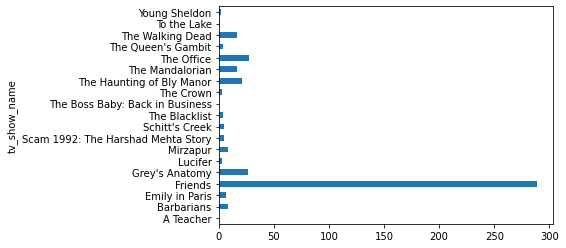

In [44]:
tweets_df[['tv_show_name', 'tweet_popularity']].groupby('tv_show_name')['tweet_popularity'].mean().plot.barh(x='tv_show_name')

It is clear that tweets about Friends are wildly more popular than tweets about any other TV shows, even if they were to be combined.

In [45]:
def extract_entities(data):
    try:
        hashtag_data = data['hashtags']
    except:
        return ''
    if len(hashtag_data) > 0:
        hashtags = ''.join([hashtag['text'] for hashtag in data['hashtags']])
    else:
        hashtags = ''
    return hashtags

In [46]:
def extract_media_presence(data):
    try:
        media_data = data['media']
        return True
    except:
        return False

In [47]:
def extract_user_popularity(data):
    return data['friends_count']

In [48]:
def extract_user_reach(data):
    return data['followers_count']

In [49]:
tweets_df['entities_list'] = tweets_df['entities'].apply(lambda x: extract_entities(x))

In [50]:
tweets_df['media_presence'] = tweets_df['entities'].apply(lambda x: extract_media_presence(x))

In [51]:
tweets_df['user_reach'] = tweets_df['user'].apply(lambda x: extract_user_reach(x))

In [52]:
tweets_df['user_popularity'] = tweets_df['user'].apply(lambda x: extract_user_popularity(x))

In [53]:
tweets_df['sentiment_score'] = tweets_df['clean_tweet'].apply(lambda x: sentiment_analysis(x))

In [54]:
tweets_sentiment = tweets_df.groupby('tv_show_name')['sentiment_score'].mean().to_dict()

In [55]:
imdb_df['avg_twitter_sentiment'] = imdb_df['Title'].map(tweets_sentiment)

<AxesSubplot:ylabel='Title'>

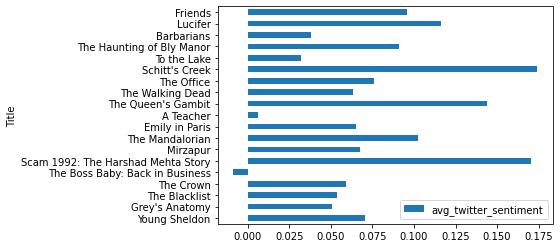

In [56]:
imdb_df[['Title', 'avg_twitter_sentiment']].plot.barh(x='Title')

In [57]:
imdb_df['imdbRating'].corr(imdb_df['avg_twitter_sentiment'])

0.7408492816346205

In [58]:
imdb_df['avg_sentiment'].corr(imdb_df['avg_twitter_sentiment'])

0.7948821790719638

The above pairs are very strongly correlated.

In [59]:
user_pop = tweets_df.groupby('tv_show_name')['user_popularity'].mean().to_dict()
user_reach = tweets_df.groupby('tv_show_name')['user_reach'].mean().to_dict()

In [60]:
imdb_df['avg_twitter_user_reach'] = imdb_df['Title'].map(user_reach)
imdb_df['avg_twitter_user_popularity'] = imdb_df['Title'].map(user_pop)

<AxesSubplot:ylabel='Title'>

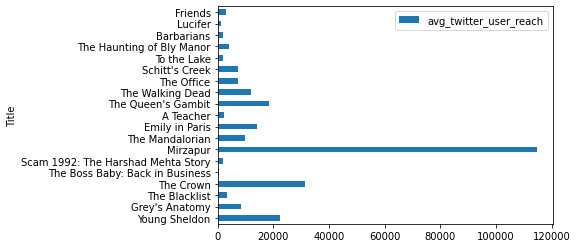

In [61]:
imdb_df[['Title', 'avg_twitter_user_reach']].plot.barh(x='Title')

<AxesSubplot:ylabel='Title'>

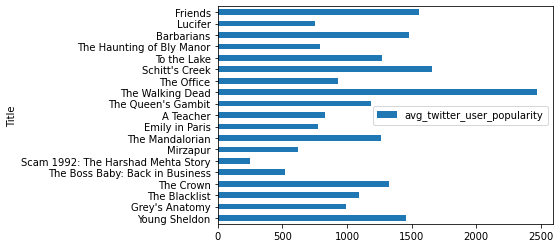

In [62]:
imdb_df[['Title', 'avg_twitter_user_popularity']].plot.barh(x='Title')

In [63]:
tv_show_tweet_count = tweets_df.groupby('tv_show_name')['text'].count().to_dict()

In [64]:
imdb_df['tweet_count'] = imdb_df['Title'].map(tv_show_tweet_count)

<AxesSubplot:ylabel='Title'>

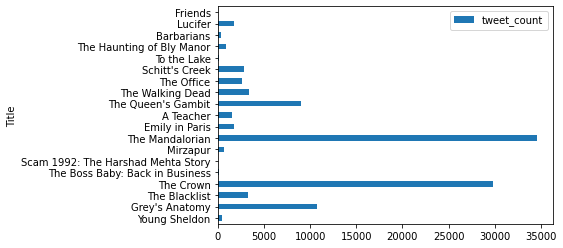

In [65]:
imdb_df[['Title', 'tweet_count']].plot.barh(x='Title')